In [1]:
import sys
import os

In [2]:
## adding scripts to path
sys.path.append("../scripts")

In [3]:
# from ...scripts.utils import get_labelencoder

In [4]:
import pandas as pd
from torchvision.io import decode_image
import numpy as np
import torch
from torchvision import utils
import matplotlib.pyplot as plt
## customs
import config as config
from _utils import get_labelencoder, get_transforms, get_test_transforms, get_means_and_stds
from datasets import ImageDataset
from model import GCDDDetector
from torchvision import tv_tensors

In [5]:
## paths
ANNOT_FP = "../data/Train.csv"
IMGS_PATH = "../data/images"

In [6]:
## other constants
labelencoder = get_labelencoder(ANNOT_FP, "class")
inference_transforms = get_test_transforms()
train_transforms=get_transforms()

In [7]:
##### FUNCTIONS
## function to get image and it's bounding boxes
def get_sample(df, img_id):
    image = decode_image(os.path.join(IMGS_PATH, img_id))
    img_df = df[df["Image_ID"] == img_id]
    target = {}
    target["boxes"] = torch.from_numpy(img_df[["xmin", "ymin", "xmax", "ymax"]].values.astype(np.float32))
    target["boxes"] = tv_tensors.BoundingBoxes(target["boxes"], format="XYXY", canvas_size=image.shape[-2:])
    target["labels"] = torch.tensor(labelencoder.transform(img_df["class"]), dtype=torch.int64)

    return image, target

def get_fmap_fpn_layer(fmap_dict, layer_name):
    fmap = fmap_dict[layer_name].squeeze(0)
    fmap = normalize_fmap(fmap)
    return fmap.mean(dim=0)
    
def normalize_fmap(fmap):
    fmin = fmap.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
    fmax = fmap.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]

    fmap_norm = (fmap-fmin)/(fmax-fmin)
    return fmap_norm

def draw_bboxes(image, bbox_dict, width=4, color="blue", font_size=50):
    font = "/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf"
    boxes = bbox_dict["boxes"]
    labels = bbox_dict["labels"]
    return utils.draw_bounding_boxes(image, boxes, [str(label.item()) for label in labels], width=width, font=font, font_size=font_size, colors=[color] * len(labels))

### Getting data

In [8]:
## reading csv
df = pd.read_csv(ANNOT_FP)
images = df["Image_ID"].unique()

### Getting Model

In [9]:
model = GCDDDetector.load_from_checkpoint(config.CHECKPOINT_LOAD_PATH,
                                                  num_classes=24,
                                                  map_location="cpu"
                                                 )
model.eval();

### Getting images of Corn_Cercospora_Leaf_Spot

In [10]:
ccls_images = df[df["class"]== "Tomato_Septoria"]["Image_ID"].unique()
current_img_id = ccls_images[128] 

In [11]:
# id_16v82n.jpg
current_img_id

'id_bqfw1w.jpg'

In [32]:
image, target = get_sample(df, current_img_id)
image_t, target_t = train_transforms(image, target)

### Predicted bouding boxes and target

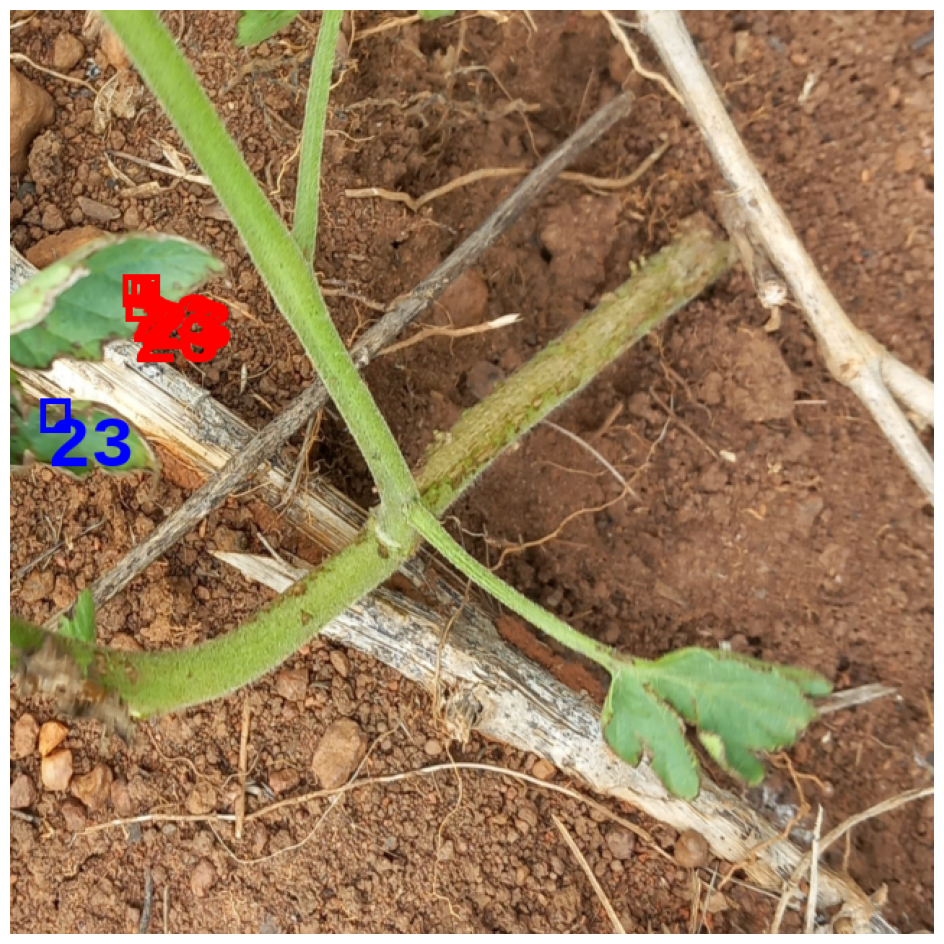

In [33]:
with torch.no_grad():
    preds = model([image_t])

# img_bbox_target = draw_bboxes(image, target)
# img_bbox_preds = draw_bboxes(image, preds[0], color="red")
# grid =  utils.make_grid([img_bbox_target, img_bbox_preds])

bbox_img = draw_bboxes(image_t, target_t)
bbox_img = draw_bboxes(bbox_img, preds[0], color="red")


plt.figure(figsize=(15,12))
plt.imshow(bbox_img.permute(1,2,0).cpu().numpy(), cmap="viridis")
plt.axis("off")
plt.show()

In [34]:
target["boxes"][:,2]- target["boxes"][:,0]

tensor([ 75.1260,  66.9263,  90.7417, 108.0784, 101.6138,  48.3861,  76.4272,  51.3806, 142.1222,  90.6297, 103.2229,  50.6250, 121.4132,  51.3666,  60.5038,  62.4907,  68.2275,  57.4953,  80.1353])

In [35]:
target_t["boxes"][:,2]- target_t["boxes"][:,0]

tensor([19.7747])

In [109]:
temp_imgs = df[df["class"] == "Corn_Streak"]["Image_ID"].unique()
df[df["Image_ID"].isin(temp_imgs)]["class"].value_counts()

class
Corn_Streak                  3180
Corn_Cercospora_Leaf_Spot     264
Corn_Northern_Leaf_Blight     128
Corn_Common_Rust               69
Corn_Healthy                   37
Name: count, dtype: int64

In [110]:
labelencoder.holder

{'Corn_Cercospora_Leaf_Spot': 1,
 'Corn_Common_Rust': 2,
 'Corn_Healthy': 3,
 'Corn_Northern_Leaf_Blight': 4,
 'Corn_Streak': 5,
 'Pepper_Bacterial_Spot': 6,
 'Pepper_Cercospora': 7,
 'Pepper_Early_Blight': 8,
 'Pepper_Fusarium': 9,
 'Pepper_Healthy': 10,
 'Pepper_Late_Blight': 11,
 'Pepper_Leaf_Blight': 12,
 'Pepper_Leaf_Curl': 13,
 'Pepper_Leaf_Mosaic': 14,
 'Pepper_Septoria': 15,
 'Tomato_Bacterial_Spot': 16,
 'Tomato_Early_Blight': 17,
 'Tomato_Fusarium': 18,
 'Tomato_Healthy': 19,
 'Tomato_Late_Blight': 20,
 'Tomato_Leaf_Curl': 21,
 'Tomato_Mosaic': 22,
 'Tomato_Septoria': 23}

### Comparing feature maps

In [111]:
model.detector.backbone(image_t.unsqueeze(0)).keys()

odict_keys(['0', '1', 'pool'])

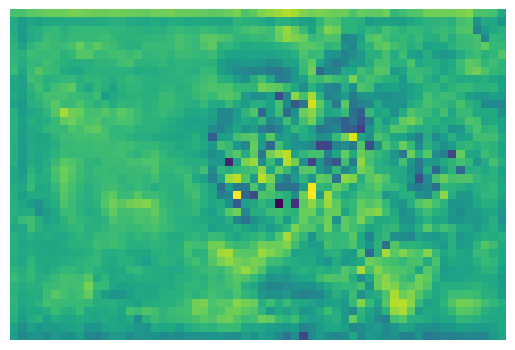

In [35]:
with torch.no_grad():
    fmap = model.detector.backbone(image_t.unsqueeze(0))
    
fmap = get_fmap_fpn_layer(fmap, "0")

# grid = utils.make_grid(fmap, normalize=False)


plt.figure()
plt.imshow(fmap.cpu().numpy(), cmap="viridis")
plt.axis("off")
plt.show()

In [36]:
model.detector.backbone(image_t.unsqueeze(0))["pool"].shape

torch.Size([1, 256, 20, 30])

In [21]:
from torchvision.models import mobilenet_v3_large
tempm = mobilenet_v3_large().features
# tempm.features[0](image_t.unsqueeze(0)).shape
[i for i,b in enumerate(tempm) if getattr(b, "_is_cn", False)]

[2, 4, 7, 13]

## Checking region proposals

In [22]:
from torchvision.models.detection.transform import GeneralizedRCNNTransform, resize_boxes
from collections import OrderedDict

In [23]:
max_size = np.max(image_t.shape[1:])
min_size = np.min(image_t.shape[1:])
# image_mean = [0.485, 0.456, 0.406]
# image_std = [0.229, 0.224, 0.225]
image_mean=[0.4763, 0.5514, 0.3163]
image_std=[0.2901, 0.2821, 0.2724]
grcnn_transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std)

In [24]:
images_rt, targets_rt = grcnn_transform([image_t], [target_t])

In [25]:
# temp = pd.read_csv("../submissions/submission_10.csv")
# temp["width"] = (temp["xmax"] - temp["xmin"])
# temp.sort_values("width").head(30)
features = model.detector.backbone(image_t.unsqueeze(0))
# features = features = OrderedDict([("0", features)])
proposals, proposal_losses = model.detector.rpn(images_rt, features, targets_rt)

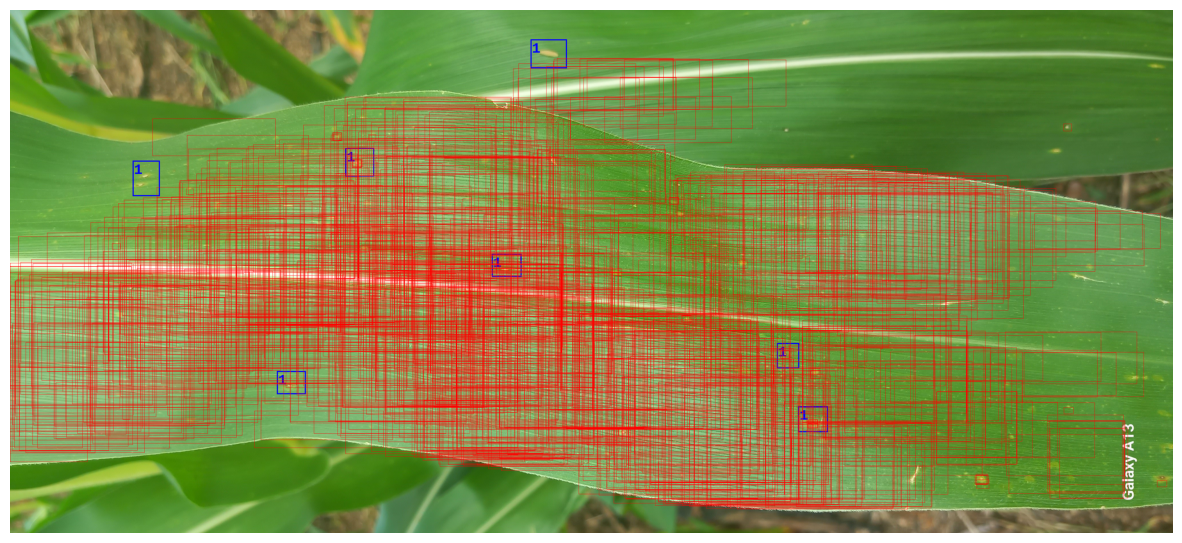

In [26]:
labels = torch.ones(len(proposals[0])) * -1

proposal_bbox_dict = {"boxes": proposals[0], "labels": labels}


bbox_img = draw_bboxes(image, targets_rt[0])
bbox_img = draw_bboxes(bbox_img, proposal_bbox_dict, color="red", width=1, font_size=1)


plt.figure(figsize=(15,12))
plt.imshow(bbox_img.permute(1,2,0).cpu().numpy(), cmap="viridis")
plt.axis("off")
plt.show()

In [27]:
model.detector.roi_heads(features, proposals, images_rt.image_sizes, targets_rt)

([{'boxes': tensor([[3389.9216, 1631.9265, 3428.5642, 1665.2964],
           [2136.6008, 1467.8977, 2170.6545, 1497.4060],
           [1202.6102,  527.3358, 1236.9015,  553.1185],
           [  10.9862,  923.5695,  344.0506, 1541.5851],
           [2704.9746, 1197.5486, 2736.5200, 1224.3167],
           [3113.9277,  623.3420, 3419.9087,  986.3527],
           [2798.4690, 1439.1904, 2834.4700, 1469.0977],
           [2814.8269,  613.6234, 3398.8381,  979.7656],
           [2006.7681, 1058.9503, 2037.5718, 1088.5248],
           [2359.6960, 1074.0768, 2392.3215, 1097.9833],
           [1135.0743,  438.0863, 1160.0782,  461.3979],
           [2443.4819,  599.0480, 2726.3481,  819.4520],
           [3680.3274, 1451.1956, 3898.6677, 1695.7305],
           [2297.3438, 1301.1959, 2760.6982, 1687.2277],
           [ 372.8191,  973.7270,  685.4271, 1282.8623],
           [2203.5032, 1165.1138, 2580.2854, 1651.5769],
           [1921.1145,  475.3823, 2197.6707,  724.9942],
           [2814.4126,

In [28]:
import sys

detections = None
proposals = None

holder = {}
def trace_function(frame, event, arg):
    # Hook into the function's execution
    if event == "call":
        pass
    elif event == "return":
        pass
    elif event == "line":
        if "proposals" in frame.f_locals:
            holder["proposals"] = frame.f_locals["proposals"]
        if "detections" in frame.f_locals:
            # if "detections" in holder:
            holder["detections"] = frame.f_locals["detections"]
            # else: holder["detections"] = frame.f_locals["detections"]
        if "original_image_sizes" in frame.f_locals:
            holder["original_image_sizes"] = frame.f_locals["original_image_sizes"]
        if "images" in frame.f_locals:
            if hasattr(frame.f_locals["images"], "image_sizes"):
                holder["new_image_sizes"] = frame.f_locals["images"].image_sizes
    return trace_function

def inspect_during_execution(func, *args, **kwargs):
    # Set the trace function
    sys.settrace(trace_function)
    try:
        return func(*args, **kwargs)
    finally:
        # Ensure tracing is removed after function execution
        sys.settrace(None)


# Inspect the function without pausing
def get_detections_and_proposals():
    model.eval()
    with torch.no_grad():
        result = inspect_during_execution(model.detector.forward, [image_t])
    proposal_bboxes = resize_boxes(holder["proposals"][0], holder["new_image_sizes"][0], holder["original_image_sizes"][0])

    return result[0], {"boxes": proposal_bboxes, "labels":torch.ones(len(proposal_bboxes))*-1}

In [29]:
holder

{}

In [30]:
detections, proposals = get_detections_and_proposals()
detections

{'boxes': tensor([[3.9960e+02, 5.5395e+02, 5.2231e+02, 6.4567e+02],
         [2.7557e+03, 1.4059e+03, 2.8706e+03, 1.4930e+03],
         [9.3169e+02, 1.2763e+03, 1.0265e+03, 1.3618e+03],
         [2.0949e+03, 1.4433e+03, 2.2085e+03, 1.5267e+03],
         [1.8470e+03, 1.1390e+02, 1.9428e+03, 1.9066e+02],
         [3.2507e+03, 9.9246e+02, 3.3486e+03, 1.0685e+03],
         [3.3440e+03, 1.6070e+03, 3.4551e+03, 1.6844e+03],
         [3.1141e+03, 7.2753e+02, 4.0555e+03, 1.7152e+03],
         [2.5296e+03, 1.2338e+03, 2.6280e+03, 1.3128e+03],
         [2.1052e+03, 7.1876e+01, 2.7620e+03, 4.2976e+02],
         [1.1751e+03, 5.1032e+02, 1.2605e+03, 5.7743e+02],
         [2.8440e+03, 2.3722e+01, 3.9585e+03, 4.5043e+02],
         [9.8903e+02, 4.2364e+02, 1.8349e+03, 1.3958e+03],
         [2.7312e+03, 7.1284e+02, 2.8173e+03, 7.7235e+02],
         [1.7942e+01, 8.7671e+02, 3.5608e+02, 1.5412e+03],
         [2.5237e+03, 8.5588e+02, 2.6138e+03, 9.3474e+02],
         [2.6270e+02, 4.8098e+02, 1.9336e+03, 1

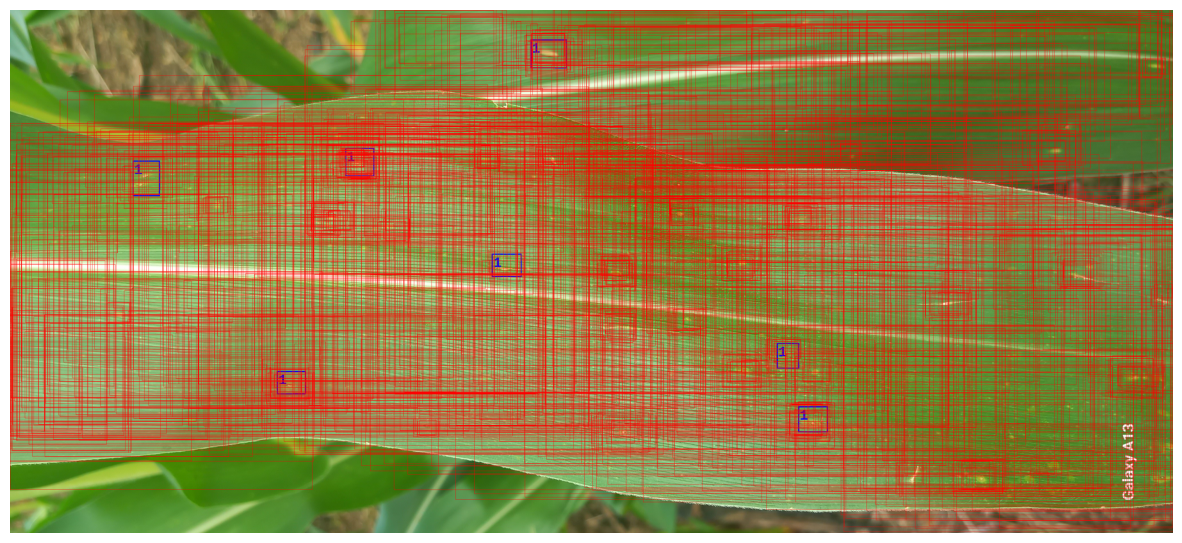

In [31]:
bbox_img = draw_bboxes(image, target_t)
bbox_img = draw_bboxes(bbox_img, proposals, color="red", width=1, font_size=1)


plt.figure(figsize=(15,12))
plt.imshow(bbox_img.permute(1,2,0).cpu().numpy(), cmap="viridis")
plt.axis("off")
plt.show()

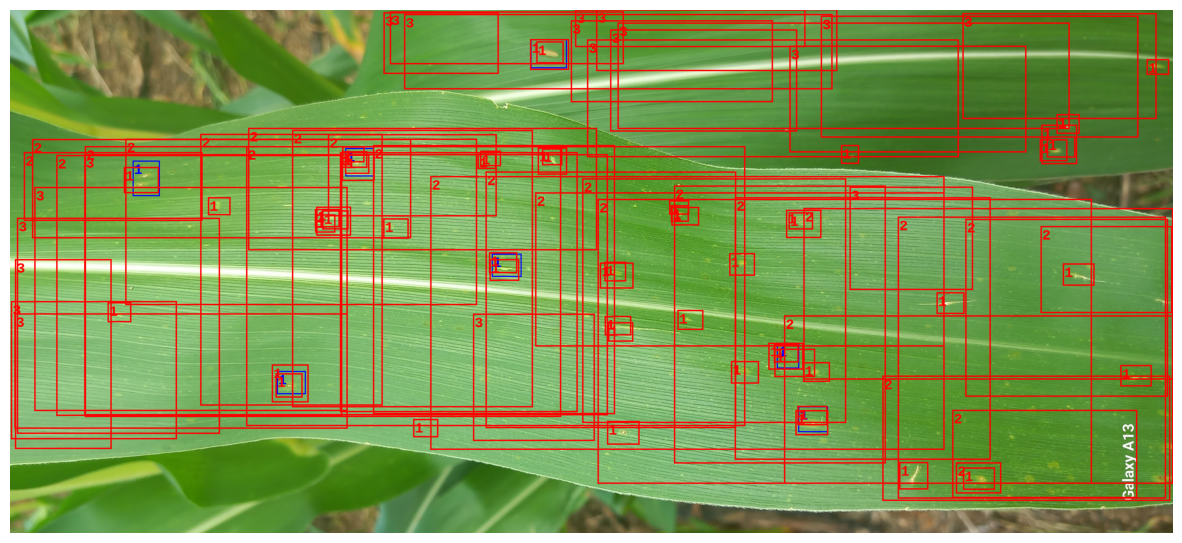

In [32]:
bbox_img = draw_bboxes(image, target_t)
bbox_img = draw_bboxes(bbox_img, detections, color="red", width=5, font_size=50)


plt.figure(figsize=(15,12))
plt.imshow(bbox_img.permute(1,2,0).cpu().numpy(), cmap="viridis")
plt.axis("off")
plt.show()

In [33]:
temp = pd.read_csv(ANNOT_FP)
temp[temp["Image_ID"] == "id_1qckzv.jpg"].sort_values("xmin")

Image_ID  confidence               class         ymin  \
522    id_1qckzv.jpg         1.0     Tomato_Septoria  1778.597946   
555    id_1qckzv.jpg         1.0     Pepper_Septoria  1778.597946   
37629  id_1qckzv.jpg         1.0     Pepper_Septoria  2630.719502   
525    id_1qckzv.jpg         1.0     Tomato_Septoria  2630.719502   
521    id_1qckzv.jpg         1.0     Pepper_Septoria  1646.210358   
...              ...         ...                 ...          ...   
533    id_1qckzv.jpg         1.0     Tomato_Septoria  1187.890093   
535    id_1qckzv.jpg         1.0     Tomato_Septoria  1342.754572   
34015  id_1qckzv.jpg         1.0     Pepper_Septoria  1342.754572   
558    id_1qckzv.jpg         1.0  Pepper_Late_Blight  1719.310559   
557    id_1qckzv.jpg         1.0  Tomato_Late_Blight  1719.310559   

              xmin         ymax         xmax  
522       6.756762  2127.303419   328.915853  
555       6.756762  2127.303419   328.915853  
37629   121.112885  2854.446831   366.450789  
525     121.112885  2854.446831   366.450789  
521     353.138430  1851.994051   735.611382  
...            ...          ...          ...  
533    3777.680691  1319.449148  3916.638054  
535    3836.042074  1718.624061  3970.810481  
34015  3836.042074  1718.624061  3970.810481  
558    3912.449098  1933.592623  4032.000000  
557    3912.449098  1933.592623  4032.000000  

[62 rows x 7 columns]

In [34]:
temp.shape

(41029, 7)

In [35]:
temp.drop_duplicates(subset=["xmin", "ymin", "xmax", "ymax"])

Image_ID  confidence                      class         ymin  \
0      id_11543h.jpg         1.0      Pepper_Bacterial_Spot   194.649671   
1      id_11543h.jpg         1.0      Pepper_Bacterial_Spot   149.632401   
2      id_11543h.jpg         1.0      Pepper_Bacterial_Spot   234.046875   
3      id_11543h.jpg         1.0      Pepper_Bacterial_Spot   221.277138   
4      id_11ee1c.jpg         1.0            Pepper_Fusarium  2000.563598   
...              ...         ...                        ...          ...   
41023  id_tw4lex.jpg         1.0      Pepper_Bacterial_Spot  1110.008844   
41024  id_38x7ln.jpg         1.0                Corn_Streak   608.472222   
41025  id_7uqmqp.jpg         1.0               Corn_Healthy  1483.095425   
41026  id_bnqorw.jpg         1.0  Corn_Cercospora_Leaf_Spot   943.260816   
41027  id_m2kklk.jpg         1.0            Tomato_Septoria  1855.337090   

              xmin         ymax         xmax  
0       328.803454   208.107730   341.967928  
1       256.768914   162.910362   266.195724  
2       327.138158   252.712993   338.876645  
3       340.411184   238.593750   354.651316  
4       989.588908  2184.252196  1401.748952  
...            ...          ...          ...  
41023  2232.019671  1193.680719  2291.961126  
41024   817.741770   736.352881   997.047325  
41025   818.249483  1786.752393  1152.860096  
41026  1015.079256  1007.928503  1133.177119  
41027  1748.733977  2046.688525  1868.580553  

[37865 rows x 7 columns]

In [39]:
temp[temp["class"] == "box_nms_thresh"]

NameError: name 'temp' is not defined